# About this notebook
- tokenizer(anchor[SEP]target | CPC)
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

# Directory settings

In [1]:
# ====================================================
# Directory settings
# ====================================================
comp_name = 'us-patent-phrase-to-phrase-matching'
nb_name = 'nb005t-deberta-v3-large'

import sys
print(sys.version)
if "google.colab" in sys.modules:
    from google.colab import drive
    drive.mount("/content/drive")
    base = f"/content/drive/MyDrive/colab_notebooks/kaggle/{comp_name}/notebooks"
    %cd {base}


import os
INPUT_DIR = f'../input/{comp_name}/'
if 'kaggle_web_client' in sys.modules:
    OUTPUT_DIR = './'
else:
    OUTPUT_DIR = f'../input/{nb_name}/'
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/colab_notebooks/kaggle/us-patent-phrase-to-phrase-matching/notebooks


# CFG

In [2]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug=False
    wandb=True
    wandbproject=comp_name
    wandbgroup=nb_name
    wandbname='exp003.002.001'
    _wandb_kernel='riow1983'
    apex=True
    print_freq=100
    num_workers=8
    model="microsoft/deberta-v3-large"
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=4
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=16
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    #### AWP
    adv_lr=1e-6
    adv_eps=1e-3
    #### AWPAWP
    n_fold=10
    trn_fold=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]
    CFG.wandb = False

In [3]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    if 'google.colab' in sys.modules:
        !pip install wandb
    import wandb

    try:
        if 'kaggle_web_client' in sys.modules:
            from kaggle_secrets import UserSecretsClient
            user_secrets = UserSecretsClient()
            secret_value_0 = user_secrets.get_secret("wandb_api")
        else:
            import json
            f = open("../../wandb.json", "r")
            json_data = json.load(f)
            secret_value_0 = json_data["wandb_api"]
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))
    
    run = wandb.init(
        dir=OUTPUT_DIR,
        project=CFG.wandbproject,
        group=CFG.wandbgroup,
        name=CFG.wandbname, 
        config=class2dict(CFG),
        job_type="train",
        anonymous=anony)
    print(f"wandb run id: {run.id}")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 15.3 MB/s 
     |████████████████████████████████| 181 kB 82.9 MB/s 
     |████████████████████████████████| 145 kB 55.9 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=f914824d8db80075f053f55b7f49ce308c24c4f8944ed929eea978973aa56698
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: riow1983. Use `wandb login --relogin` to force relogin


wandb run id: 7ufuddux


# Library

In [4]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold


# # PyTorchのバージョンを1.10.1に下げる (Google Colabなのでpipでやる)
# os.system('pip uninstall -y torch torchvision torchaudio')
# os.system('pip install torch==1.10.1+cu111 torchvision==0.11.2+cu111 torchaudio==0.10.1 -f https://download.pytorch.org/whl/torch_stable.html')


import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

os.system('pip uninstall -y transformers')
os.system('pip uninstall -y tokenizers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels transformers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels tokenizers')
# os.system('python -m pip install transformers')
# os.system('python -m pip install tokenizers')
os.system('pip install sentencepiece')
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
tokenizers.__version__: 0.12.1
transformers.__version__: 4.18.0
env: TOKENIZERS_PARALLELISM=true


# Utils

In [5]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [6]:
# ====================================================
# Data Loading
# ====================================================
# #### AUG
# # train = pd.read_csv(INPUT_DIR+'train.csv')
# train = pd.read_csv('../input/kagglenb006-back-translate-aug-data/train.csv')
# #### AUGAUG
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [7]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}

    # for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
    #     with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
    #         s = f.read()
    #     pattern = f'{cpc}\t\t.+'
    #     result = re.findall(pattern, s)
    #     cpc_result = result[0].lstrip(pattern)
    #     for context in [c for c in contexts if c[0] == cpc]:
    #         pattern = f'{context}\t\t.+'
    #         result = re.findall(pattern, s)
    #         results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    
    # Credits to https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/discussion/324928
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        pattern = "^"+pattern[:-2]
        cpc_result = re.sub(pattern, "", result[0])
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            pattern = "^"+pattern[:-2]
            results[context] = cpc_result + ". " + re.sub(pattern, "", result[0])

    
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [8]:
# train['text'] = train['anchor'] + '[SEP]' + train['target'] + '[SEP]'  + train['context_text']
# test['text'] = test['anchor'] + '[SEP]' + test['target'] + '[SEP]'  + test['context_text']

train['text'] = train['anchor'] + '[SEP]' + train['target']
test['text'] = test['anchor'] + '[SEP]' + test['target']

train['text2'] = train['context_text']
test['text2'] = test['context_text']


display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text,text2
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text,text,text2
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural network,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


# EDA

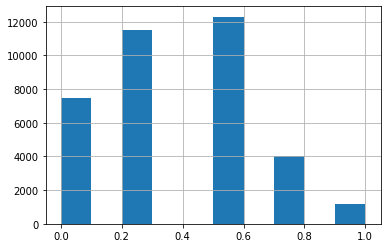

In [9]:
train['score'].hist()

In [10]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [11]:
# ====================================================
# CV split
# ====================================================
# train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
# Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
# for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
#     train.loc[val_index, 'fold'] = int(n)
# train['fold'] = train['fold'].astype(int)
# display(train.groupby('fold').size())


# #### AUG
# aug = train[train['is_aug']==1].reset_index(drop=True)
# train = train[train['is_aug']==0].reset_index(drop=True)
# #### AUGAUG


# Credits to https://www.kaggle.com/code/hannes82/pppm-deberta-v3-large-closing-the-cv-lb-gap/notebook#CV-split
#credits to: https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

!pip install -q iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

dfx = pd.get_dummies(train, columns=["score"]).groupby(["anchor"], as_index=False).sum()
cols = [c for c in dfx.columns if c.startswith("score_") or c == "anchor"]
dfx = dfx[cols]

mskf = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)
labels = [c for c in dfx.columns if c != "anchor"]
dfx_labels = dfx[labels]
dfx["fold"] = -1

for fold, (trn_, val_) in enumerate(mskf.split(dfx, dfx_labels)):
    print(len(trn_), len(val_))
    dfx.loc[val_, "fold"] = fold

train = train.merge(dfx[["anchor", "fold"]], on="anchor", how="left")
del dfx



# #### AUG
# res = []
# for fold in range(CFG.n_fold):
#     val_ids = train.loc[train['fold']==fold, 'id'].values
#     to_add_aug = aug[~aug['id'].isin(val_ids)].reset_index(drop=True)
#     to_add_aug['fold'] = fold+10
#     res.append(to_add_aug)

# to_add_aug = pd.concat(res, axis=0, ignore_index=True)
# train = pd.concat([train, to_add_aug], axis=0, ignore_index=True)
# del aug, to_add_aug, res, val_ids
# #### AUGAUG

print(train.fold.value_counts())

660 73
660 73
659 74
659 74
660 73
659 74
660 73
660 73
660 73
660 73
0    3954
9    3947
4    3902
6    3647
1    3634
3    3604
2    3524
5    3517
8    3487
7    3257
Name: fold, dtype: int64


In [12]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [13]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [14]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
# CFG.max_len = max(max(lengths_dict['anchor'])+max(lengths_dict['target'])+3, max(lengths_dict['context_text'])+2)
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 133


In [15]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text, text2):
    inputs = cfg.tokenizer(text, text2,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.texts2 = df['text2'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item], self.texts2[item])
        #inputs2 = prepare_input(self.cfg, self.texts2[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        #return inputs, inputs2, label
        return inputs, label

In [16]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [17]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        
        # outputs2 = self.model(**inputs2)
        # last_hidden_states2 = outputs2[0]
        
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        #feature2 = torch.mean(last_hidden_states2, dim=1)
        #feature += feature2
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output

# Helpler functions

In [18]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

#### AWP
#def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device, scaler, score, awp):
#### AWPAWP
    model.train()
    # AWP
    #scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    # AWPAWP
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0

    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        # for k, v in inputs2.items():
        #     inputs2[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        #### AWP
        if score > 0.75:
            awp.attack_backward(inputs['input_ids'], labels, inputs['attention_mask'], step) 
        #### AWPAWP

        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        # for k, v in inputs2.items():
        #     inputs2[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        # for k, v in inputs[1].items():
        #     inputs[1][k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [19]:
#### AWP
class AWP:
    def __init__(
        self,
        model,
        optimizer,
        adv_param="weight",
        adv_lr=1,
        adv_eps=0.2,
        start_epoch=0,
        adv_step=1,
        scaler=None
    ):
        self.model = model
        self.optimizer = optimizer
        self.adv_param = adv_param
        self.adv_lr = adv_lr
        self.adv_eps = adv_eps
        self.start_epoch = start_epoch
        self.adv_step = adv_step
        self.backup = {}
        self.backup_eps = {}
        self.scaler = scaler

    def attack_backward(self, x, y, attention_mask,epoch):
        if (self.adv_lr == 0) or (epoch < self.start_epoch):
            return None

        self._save() 
        for i in range(self.adv_step):
            self._attack_step() 
            with torch.cuda.amp.autocast():
                adv_loss, tr_logits = self.model(input_ids=x, attention_mask=attention_mask, labels=y)
                adv_loss = adv_loss.mean()
            self.optimizer.zero_grad()
            self.scaler.scale(adv_loss).backward()
            
        self._restore()

    def _attack_step(self):
        e = 1e-6
        for name, param in self.model.named_parameters():
            if param.requires_grad and param.grad is not None and self.adv_param in name:
                norm1 = torch.norm(param.grad)
                norm2 = torch.norm(param.data.detach())
                if norm1 != 0 and not torch.isnan(norm1):
                    r_at = self.adv_lr * param.grad / (norm1 + e) * (norm2 + e)
                    param.data.add_(r_at)
                    param.data = torch.min(
                        torch.max(param.data, self.backup_eps[name][0]), self.backup_eps[name][1]
                    )
                # param.data.clamp_(*self.backup_eps[name])

    def _save(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad and param.grad is not None and self.adv_param in name:
                if name not in self.backup:
                    self.backup[name] = param.data.clone()
                    grad_eps = self.adv_eps * param.abs().detach()
                    self.backup_eps[name] = (
                        self.backup[name] - grad_eps,
                        self.backup[name] + grad_eps,
                    )

    def _restore(self,):
        for name, param in self.model.named_parameters():
            if name in self.backup:
                param.data = self.backup[name]
        self.backup = {}
        self.backup_eps = {}

#### AWPAWP

In [20]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    
    # #### AUG
    # train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    # train_folds_aug = train_folds[train_folds['fold']==fold+10].reset_index(drop=True)
    # train_folds_base = train_folds[train_folds['fold']<10].reset_index(drop=True)
    # train_folds = pd.concat([train_folds_base, train_folds_aug], axis=0, ignore_index=True)
    # del train_folds_aug, train_folds_base
    # #### AUGAUG
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)

    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.
    #### AWP
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    awp = AWP(model,
              optimizer,
              adv_lr=CFG.adv_lr,
              adv_eps=CFG.adv_eps,
              start_epoch=num_train_steps/CFG.epochs,
              scaler=scaler)
    score = 0.
    #### AWPAWP
    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        #### AWP
        #avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device, scaler, score, awp)
        #### AWPAWP

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [21]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()




    # Push to LINE
    import requests

    def send_line_notification(message):
        import json
        f = open("../../line.json", "r")
        json_data = json.load(f)
        line_token = json_data["kagglePush"]
        endpoint = 'https://notify-api.line.me/api/notify'
        message = "\n{}".format(message)
        payload = {'message': message}
        headers = {'Authorization': 'Bearer {}'.format(line_token)}
        requests.post(endpoint, data=payload, headers=headers)

    if CFG.wandb:
        send_line_notification(f"Training of {CFG.wandbproject+'/'+CFG.wandbgroup+'/'+CFG.wandbname} has been done. See {run.url}")
    else:
        send_line_notification(f"Training of {CFG.wandbproject+'/'+CFG.wandbgroup+'/'+CFG.wandbname} has been done.")

========== fold: 0 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClas

Epoch: [1][0/2032] Elapsed 0m 0s (remain 26m 25s) Loss: 0.6698(0.6698) Grad: inf  LR: 0.00002000  
Epoch: [1][100/2032] Elapsed 0m 27s (remain 8m 51s) Loss: 0.6552(0.6320) Grad: 41921.7188  LR: 0.00001999  
Epoch: [1][200/2032] Elapsed 0m 54s (remain 8m 20s) Loss: 0.5296(0.6066) Grad: 45010.0078  LR: 0.00001997  
Epoch: [1][300/2032] Elapsed 1m 22s (remain 7m 51s) Loss: 0.4997(0.5936) Grad: 13322.3369  LR: 0.00001993  
Epoch: [1][400/2032] Elapsed 1m 48s (remain 7m 22s) Loss: 0.5065(0.5855) Grad: 26405.1055  LR: 0.00001988  
Epoch: [1][500/2032] Elapsed 2m 15s (remain 6m 55s) Loss: 0.5063(0.5795) Grad: 26119.7734  LR: 0.00001981  
Epoch: [1][600/2032] Elapsed 2m 42s (remain 6m 27s) Loss: 0.6406(0.5758) Grad: 11106.2959  LR: 0.00001973  
Epoch: [1][700/2032] Elapsed 3m 10s (remain 6m 1s) Loss: 0.5610(0.5728) Grad: 21092.0781  LR: 0.00001964  
Epoch: [1][800/2032] Elapsed 3m 37s (remain 5m 33s) Loss: 0.5775(0.5688) Grad: 23264.3828  LR: 0.00001952  
Epoch: [1][900/2032] Elapsed 4m 4s (re

Epoch 1 - avg_train_loss: 0.5537  avg_val_loss: 0.5614  time: 591s
Epoch 1 - Score: 0.7967
Epoch 1 - Save Best Score: 0.7967 Model


EVAL: [247/248] Elapsed 0m 40s (remain 0m 0s) Loss: 0.6381(0.5614) 
Epoch: [2][0/2032] Elapsed 0m 0s (remain 25m 28s) Loss: 0.4998(0.4998) Grad: 17176.9199  LR: 0.00001707  
Epoch: [2][100/2032] Elapsed 0m 28s (remain 8m 57s) Loss: 0.5659(0.5321) Grad: 48832.8789  LR: 0.00001679  
Epoch: [2][200/2032] Elapsed 0m 55s (remain 8m 26s) Loss: 0.4927(0.5212) Grad: 37958.6367  LR: 0.00001650  
Epoch: [2][300/2032] Elapsed 1m 22s (remain 7m 55s) Loss: 0.5458(0.5233) Grad: 34402.4141  LR: 0.00001620  
Epoch: [2][400/2032] Elapsed 1m 49s (remain 7m 25s) Loss: 0.4616(0.5212) Grad: 45942.8398  LR: 0.00001590  
Epoch: [2][500/2032] Elapsed 2m 16s (remain 6m 57s) Loss: 0.5652(0.5173) Grad: 65514.1758  LR: 0.00001558  
Epoch: [2][600/2032] Elapsed 2m 43s (remain 6m 29s) Loss: 0.4689(0.5168) Grad: 52502.7422  LR: 0.00001525  
Epoch: [2][700/2032] Elapsed 3m 10s (remain 6m 1s) Loss: 0.3894(0.5173) Grad: 63074.6914  LR: 0.00001492  
Epoch: [2][800/2032] Elapsed 3m 37s (remain 5m 34s) Loss: 0.4254(0.5169

Epoch 2 - avg_train_loss: 0.5176  avg_val_loss: 0.5587  time: 591s
Epoch 2 - Score: 0.8036
Epoch 2 - Save Best Score: 0.8036 Model


EVAL: [247/248] Elapsed 0m 40s (remain 0m 0s) Loss: 0.6329(0.5587) 
Epoch: [3][0/2032] Elapsed 0m 0s (remain 25m 42s) Loss: 0.4988(0.4988) Grad: 11779.0078  LR: 0.00001000  
Epoch: [3][100/2032] Elapsed 0m 28s (remain 8m 59s) Loss: 0.5524(0.5023) Grad: 771276.0625  LR: 0.00000961  
Epoch: [3][200/2032] Elapsed 0m 55s (remain 8m 28s) Loss: 0.5290(0.5032) Grad: 16192.3643  LR: 0.00000923  
Epoch: [3][300/2032] Elapsed 1m 22s (remain 7m 56s) Loss: 0.4994(0.5030) Grad: 10724.7676  LR: 0.00000884  
Epoch: [3][400/2032] Elapsed 1m 49s (remain 7m 26s) Loss: 0.4381(0.4992) Grad: 19537.0312  LR: 0.00000846  
Epoch: [3][500/2032] Elapsed 2m 16s (remain 6m 57s) Loss: 0.4677(0.5022) Grad: 15027.7207  LR: 0.00000808  
Epoch: [3][600/2032] Elapsed 2m 43s (remain 6m 29s) Loss: 0.5272(0.5043) Grad: 29611.5508  LR: 0.00000770  
Epoch: [3][700/2032] Elapsed 3m 10s (remain 6m 1s) Loss: 0.4368(0.5052) Grad: 11801.2188  LR: 0.00000733  
Epoch: [3][800/2032] Elapsed 3m 37s (remain 5m 34s) Loss: 0.4809(0.504

Epoch 3 - avg_train_loss: 0.5036  avg_val_loss: 0.5753  time: 590s
Epoch 3 - Score: 0.8105
Epoch 3 - Save Best Score: 0.8105 Model


EVAL: [247/248] Elapsed 0m 40s (remain 0m 0s) Loss: 0.6304(0.5753) 
Epoch: [4][0/2032] Elapsed 0m 0s (remain 25m 11s) Loss: 0.6195(0.6195) Grad: 159894.7969  LR: 0.00000293  
Epoch: [4][100/2032] Elapsed 0m 28s (remain 8m 57s) Loss: 0.4221(0.4889) Grad: 133283.2344  LR: 0.00000266  
Epoch: [4][200/2032] Elapsed 0m 55s (remain 8m 25s) Loss: 0.4198(0.4912) Grad: 11909.8066  LR: 0.00000240  
Epoch: [4][300/2032] Elapsed 1m 22s (remain 7m 53s) Loss: 0.4914(0.4921) Grad: 12812.2344  LR: 0.00000216  
Epoch: [4][400/2032] Elapsed 1m 49s (remain 7m 24s) Loss: 0.5010(0.4949) Grad: 18269.4629  LR: 0.00000192  
Epoch: [4][500/2032] Elapsed 2m 16s (remain 6m 57s) Loss: 0.6684(0.4958) Grad: 17849.8418  LR: 0.00000170  
Epoch: [4][600/2032] Elapsed 2m 43s (remain 6m 29s) Loss: 0.6269(0.4966) Grad: 15439.1885  LR: 0.00000149  
Epoch: [4][700/2032] Elapsed 3m 10s (remain 6m 1s) Loss: 0.4990(0.4964) Grad: 22674.6641  LR: 0.00000130  
Epoch: [4][800/2032] Elapsed 3m 37s (remain 5m 34s) Loss: 0.5957(0.49

Epoch 4 - avg_train_loss: 0.4940  avg_val_loss: 0.5768  time: 590s
Epoch 4 - Score: 0.8140
Epoch 4 - Save Best Score: 0.8140 Model


EVAL: [247/248] Elapsed 0m 40s (remain 0m 0s) Loss: 0.6285(0.5768) 


========== fold: 0 result ==========
Score: 0.8140
========== fold: 1 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/2052] Elapsed 0m 0s (remain 25m 29s) Loss: 0.7794(0.7794) Grad: inf  LR: 0.00002000  
Epoch: [1][100/2052] Elapsed 0m 28s (remain 9m 4s) Loss: 0.5983(0.6555) Grad: 23219.5586  LR: 0.00001999  
Epoch: [1][200/2052] Elapsed 0m 55s (remain 8m 29s) Loss: 0.5799(0.6257) Grad: 38772.6445  LR: 0.00001997  
Epoch: [1][300/2052] Elapsed 1m 22s (remain 7m 59s) Loss: 0.5372(0.6095) Grad: 16629.3008  LR: 0.00001993  
Epoch: [1][400/2052] Elapsed 1m 49s (remain 7m 30s) Loss: 0.6308(0.6006) Grad: 31863.6094  LR: 0.00001988  
Epoch: [1][500/2052] Elapsed 2m 16s (remain 7m 2s) Loss: 0.4337(0.5920) Grad: 30538.3652  LR: 0.00001982  
Epoch: [1][600/2052] Elapsed 2m 43s (remain 6m 34s) Loss: 0.5073(0.5839) Grad: 47717.8711  LR: 0.00001974  
Epoch: [1][700/2052] Elapsed 3m 10s (remain 6m 7s) Loss: 0.4236(0.5783) Grad: 31151.3984  LR: 0.00001964  
Epoch: [1][800/2052] Elapsed 3m 37s (remain 5m 40s) Loss: 0.6395(0.5739) Grad: 22035.9961  LR: 0.00001953  
Epoch: [1][900/2052] Elapsed 4m 4s (rema

Epoch 1 - avg_train_loss: 0.5559  avg_val_loss: 0.5416  time: 595s
Epoch 1 - Score: 0.8336
Epoch 1 - Save Best Score: 0.8336 Model


EVAL: [227/228] Elapsed 0m 37s (remain 0m 0s) Loss: 0.3153(0.5416) 
Epoch: [2][0/2052] Elapsed 0m 0s (remain 26m 43s) Loss: 0.4519(0.4519) Grad: 35173.4297  LR: 0.00001707  
Epoch: [2][100/2052] Elapsed 0m 28s (remain 9m 3s) Loss: 0.5289(0.5214) Grad: 55778.9961  LR: 0.00001679  
Epoch: [2][200/2052] Elapsed 0m 55s (remain 8m 28s) Loss: 0.3983(0.5136) Grad: 20476.2246  LR: 0.00001651  
Epoch: [2][300/2052] Elapsed 1m 22s (remain 7m 59s) Loss: 0.3739(0.5165) Grad: 40530.5078  LR: 0.00001621  
Epoch: [2][400/2052] Elapsed 1m 49s (remain 7m 29s) Loss: 0.5199(0.5153) Grad: 44588.2344  LR: 0.00001591  
Epoch: [2][500/2052] Elapsed 2m 16s (remain 7m 1s) Loss: 0.4252(0.5172) Grad: 39176.4492  LR: 0.00001559  
Epoch: [2][600/2052] Elapsed 2m 42s (remain 6m 33s) Loss: 0.5536(0.5189) Grad: 21588.0391  LR: 0.00001527  
Epoch: [2][700/2052] Elapsed 3m 9s (remain 6m 6s) Loss: 0.4647(0.5201) Grad: 42983.4258  LR: 0.00001494  
Epoch: [2][800/2052] Elapsed 3m 36s (remain 5m 38s) Loss: 0.5168(0.5182) G

Epoch 2 - avg_train_loss: 0.5191  avg_val_loss: 0.5470  time: 592s
Epoch 2 - Score: 0.8349
Epoch 2 - Save Best Score: 0.8349 Model


EVAL: [227/228] Elapsed 0m 37s (remain 0m 0s) Loss: 0.2433(0.5470) 
Epoch: [3][0/2052] Elapsed 0m 0s (remain 27m 25s) Loss: 0.4697(0.4697) Grad: 9092.6455  LR: 0.00001000  
Epoch: [3][100/2052] Elapsed 0m 28s (remain 9m 4s) Loss: 0.4884(0.5015) Grad: 21798.3516  LR: 0.00000962  
Epoch: [3][200/2052] Elapsed 0m 55s (remain 8m 31s) Loss: 0.5255(0.5011) Grad: 10322.8174  LR: 0.00000923  
Epoch: [3][300/2052] Elapsed 1m 22s (remain 8m 0s) Loss: 0.4201(0.5042) Grad: 5890.2671  LR: 0.00000885  
Epoch: [3][400/2052] Elapsed 1m 49s (remain 7m 30s) Loss: 0.4377(0.5037) Grad: 10809.5488  LR: 0.00000847  
Epoch: [3][500/2052] Elapsed 2m 16s (remain 7m 2s) Loss: 0.5140(0.5010) Grad: 21074.5078  LR: 0.00000810  
Epoch: [3][600/2052] Elapsed 2m 43s (remain 6m 35s) Loss: 0.6424(0.5018) Grad: 27764.5312  LR: 0.00000772  
Epoch: [3][700/2052] Elapsed 3m 11s (remain 6m 8s) Loss: 0.4134(0.5036) Grad: 29632.2012  LR: 0.00000735  
Epoch: [3][800/2052] Elapsed 3m 37s (remain 5m 40s) Loss: 0.4562(0.5038) Gra

Epoch 3 - avg_train_loss: 0.5034  avg_val_loss: 0.5610  time: 594s
Epoch 3 - Score: 0.8393
Epoch 3 - Save Best Score: 0.8393 Model


EVAL: [227/228] Elapsed 0m 37s (remain 0m 0s) Loss: 0.2461(0.5610) 
Epoch: [4][0/2052] Elapsed 0m 0s (remain 27m 32s) Loss: 0.4626(0.4626) Grad: 74916.9062  LR: 0.00000293  
Epoch: [4][100/2052] Elapsed 0m 28s (remain 9m 5s) Loss: 0.5304(0.4967) Grad: 16361.3584  LR: 0.00000266  
Epoch: [4][200/2052] Elapsed 0m 55s (remain 8m 33s) Loss: 0.4446(0.4926) Grad: 16503.3613  LR: 0.00000241  
Epoch: [4][300/2052] Elapsed 1m 22s (remain 8m 1s) Loss: 0.4580(0.4885) Grad: 13098.6699  LR: 0.00000216  
Epoch: [4][400/2052] Elapsed 1m 49s (remain 7m 32s) Loss: 0.5255(0.4932) Grad: 24623.7383  LR: 0.00000193  
Epoch: [4][500/2052] Elapsed 2m 16s (remain 7m 3s) Loss: 0.4778(0.4934) Grad: 35508.3594  LR: 0.00000171  
Epoch: [4][600/2052] Elapsed 2m 43s (remain 6m 35s) Loss: 0.4277(0.4925) Grad: 9183.6787  LR: 0.00000150  
Epoch: [4][700/2052] Elapsed 3m 10s (remain 6m 7s) Loss: 0.4629(0.4953) Grad: 160918.9062  LR: 0.00000131  
Epoch: [4][800/2052] Elapsed 3m 37s (remain 5m 40s) Loss: 0.5499(0.4954) G

Epoch 4 - avg_train_loss: 0.4947  avg_val_loss: 0.5658  time: 594s
Epoch 4 - Score: 0.8377


EVAL: [227/228] Elapsed 0m 37s (remain 0m 0s) Loss: 0.2403(0.5658) 


========== fold: 1 result ==========
Score: 0.8393
========== fold: 2 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/2059] Elapsed 0m 0s (remain 25m 56s) Loss: 0.7206(0.7206) Grad: inf  LR: 0.00002000  
Epoch: [1][100/2059] Elapsed 0m 27s (remain 9m 1s) Loss: 0.6378(0.6532) Grad: 60292.4727  LR: 0.00001999  
Epoch: [1][200/2059] Elapsed 0m 55s (remain 8m 29s) Loss: 0.5352(0.6225) Grad: 93923.5625  LR: 0.00001997  
Epoch: [1][300/2059] Elapsed 1m 22s (remain 8m 1s) Loss: 0.6173(0.6065) Grad: 92125.7188  LR: 0.00001993  
Epoch: [1][400/2059] Elapsed 1m 49s (remain 7m 32s) Loss: 0.6055(0.6007) Grad: 83238.1328  LR: 0.00001988  
Epoch: [1][500/2059] Elapsed 2m 16s (remain 7m 4s) Loss: 0.6142(0.5945) Grad: 14060.3955  LR: 0.00001982  
Epoch: [1][600/2059] Elapsed 2m 43s (remain 6m 37s) Loss: 0.5923(0.5917) Grad: 24818.1055  LR: 0.00001974  
Epoch: [1][700/2059] Elapsed 3m 10s (remain 6m 9s) Loss: 0.4924(0.5865) Grad: 17175.9121  LR: 0.00001964  
Epoch: [1][800/2059] Elapsed 3m 38s (remain 5m 42s) Loss: 0.5910(0.5832) Grad: 11544.8506  LR: 0.00001954  
Epoch: [1][900/2059] Elapsed 4m 5s (remai

Epoch 1 - avg_train_loss: 0.5667  avg_val_loss: 0.5602  time: 595s
Epoch 1 - Score: 0.7869
Epoch 1 - Save Best Score: 0.7869 Model


EVAL: [220/221] Elapsed 0m 36s (remain 0m 0s) Loss: 0.3688(0.5602) 
Epoch: [2][0/2059] Elapsed 0m 0s (remain 28m 24s) Loss: 0.5831(0.5831) Grad: 2747.3318  LR: 0.00001707  
Epoch: [2][100/2059] Elapsed 0m 28s (remain 9m 8s) Loss: 0.5408(0.5335) Grad: 1571.5675  LR: 0.00001679  
Epoch: [2][200/2059] Elapsed 0m 55s (remain 8m 33s) Loss: 0.5494(0.5366) Grad: 2499.7922  LR: 0.00001651  
Epoch: [2][300/2059] Elapsed 1m 22s (remain 8m 4s) Loss: 0.6122(0.5366) Grad: 5344.7563  LR: 0.00001622  
Epoch: [2][400/2059] Elapsed 1m 50s (remain 7m 35s) Loss: 0.4354(0.5352) Grad: 1250.2910  LR: 0.00001591  
Epoch: [2][500/2059] Elapsed 2m 17s (remain 7m 6s) Loss: 0.4844(0.5316) Grad: 3123.3423  LR: 0.00001560  
Epoch: [2][600/2059] Elapsed 2m 44s (remain 6m 38s) Loss: 0.5673(0.5348) Grad: 1113.2417  LR: 0.00001528  
Epoch: [2][700/2059] Elapsed 3m 11s (remain 6m 10s) Loss: 0.5443(0.5351) Grad: 2835.5977  LR: 0.00001495  
Epoch: [2][800/2059] Elapsed 3m 38s (remain 5m 42s) Loss: 0.6819(0.5343) Grad: 22

Epoch 2 - avg_train_loss: 0.5266  avg_val_loss: 0.5500  time: 595s
Epoch 2 - Score: 0.8236
Epoch 2 - Save Best Score: 0.8236 Model


EVAL: [220/221] Elapsed 0m 36s (remain 0m 0s) Loss: 0.3504(0.5500) 
Epoch: [3][0/2059] Elapsed 0m 0s (remain 28m 14s) Loss: 0.4816(0.4816) Grad: 4229.1157  LR: 0.00001000  
Epoch: [3][100/2059] Elapsed 0m 28s (remain 9m 5s) Loss: 0.5064(0.5128) Grad: 2982.9998  LR: 0.00000962  
Epoch: [3][200/2059] Elapsed 0m 55s (remain 8m 33s) Loss: 0.4778(0.5082) Grad: 1783.5828  LR: 0.00000924  
Epoch: [3][300/2059] Elapsed 1m 22s (remain 8m 2s) Loss: 0.5400(0.5093) Grad: 2547.6067  LR: 0.00000886  
Epoch: [3][400/2059] Elapsed 1m 49s (remain 7m 33s) Loss: 0.4853(0.5083) Grad: 2169.4526  LR: 0.00000848  
Epoch: [3][500/2059] Elapsed 2m 16s (remain 7m 5s) Loss: 0.5259(0.5050) Grad: 12099.8711  LR: 0.00000810  
Epoch: [3][600/2059] Elapsed 2m 43s (remain 6m 37s) Loss: 0.4897(0.5038) Grad: 3439.7898  LR: 0.00000773  
Epoch: [3][700/2059] Elapsed 3m 11s (remain 6m 10s) Loss: 0.5887(0.5040) Grad: 10928.5332  LR: 0.00000736  
Epoch: [3][800/2059] Elapsed 3m 38s (remain 5m 42s) Loss: 0.5916(0.5030) Grad: 

Epoch 3 - avg_train_loss: 0.5031  avg_val_loss: 0.5553  time: 596s
Epoch 3 - Score: 0.8287
Epoch 3 - Save Best Score: 0.8287 Model


EVAL: [220/221] Elapsed 0m 36s (remain 0m 0s) Loss: 0.3452(0.5553) 
Epoch: [4][0/2059] Elapsed 0m 0s (remain 28m 21s) Loss: 0.5726(0.5726) Grad: 4231.6260  LR: 0.00000293  
Epoch: [4][100/2059] Elapsed 0m 28s (remain 9m 9s) Loss: 0.5191(0.4977) Grad: 9399.5830  LR: 0.00000266  
Epoch: [4][200/2059] Elapsed 0m 55s (remain 8m 34s) Loss: 0.5034(0.4980) Grad: 10486.5322  LR: 0.00000241  
Epoch: [4][300/2059] Elapsed 1m 22s (remain 8m 3s) Loss: 0.4161(0.4957) Grad: 4795.1021  LR: 0.00000217  
Epoch: [4][400/2059] Elapsed 1m 49s (remain 7m 34s) Loss: 0.4897(0.4977) Grad: 3135.6633  LR: 0.00000194  
Epoch: [4][500/2059] Elapsed 2m 16s (remain 7m 5s) Loss: 0.5801(0.4959) Grad: 12985.7891  LR: 0.00000172  
Epoch: [4][600/2059] Elapsed 2m 43s (remain 6m 37s) Loss: 0.5444(0.4955) Grad: 3689.7490  LR: 0.00000151  
Epoch: [4][700/2059] Elapsed 3m 11s (remain 6m 10s) Loss: 0.4662(0.4949) Grad: 4596.5752  LR: 0.00000131  
Epoch: [4][800/2059] Elapsed 3m 38s (remain 5m 42s) Loss: 0.6026(0.4962) Grad: 

Epoch 4 - avg_train_loss: 0.4946  avg_val_loss: 0.5612  time: 596s
Epoch 4 - Score: 0.8278


EVAL: [220/221] Elapsed 0m 36s (remain 0m 0s) Loss: 0.3427(0.5612) 


========== fold: 2 result ==========
Score: 0.8287
========== fold: 3 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/2054] Elapsed 0m 0s (remain 26m 14s) Loss: 0.7883(0.7883) Grad: inf  LR: 0.00002000  
Epoch: [1][100/2054] Elapsed 0m 27s (remain 8m 58s) Loss: 0.6801(0.6487) Grad: 34460.2578  LR: 0.00001999  
Epoch: [1][200/2054] Elapsed 0m 55s (remain 8m 27s) Loss: 0.6260(0.6186) Grad: 85682.0078  LR: 0.00001997  
Epoch: [1][300/2054] Elapsed 1m 22s (remain 7m 58s) Loss: 0.5677(0.6022) Grad: 33566.2656  LR: 0.00001993  
Epoch: [1][400/2054] Elapsed 1m 49s (remain 7m 30s) Loss: 0.5713(0.5943) Grad: 38258.8008  LR: 0.00001988  
Epoch: [1][500/2054] Elapsed 2m 16s (remain 7m 3s) Loss: 0.5826(0.5856) Grad: 88474.3203  LR: 0.00001982  
Epoch: [1][600/2054] Elapsed 2m 43s (remain 6m 35s) Loss: 0.4249(0.5801) Grad: 43529.6484  LR: 0.00001974  
Epoch: [1][700/2054] Elapsed 3m 10s (remain 6m 8s) Loss: 0.5201(0.5764) Grad: 31838.4355  LR: 0.00001964  
Epoch: [1][800/2054] Elapsed 3m 37s (remain 5m 40s) Loss: 0.5850(0.5733) Grad: 120763.5625  LR: 0.00001953  
Epoch: [1][900/2054] Elapsed 4m 4s (re

Epoch 1 - avg_train_loss: 0.5566  avg_val_loss: 0.5535  time: 595s
Epoch 1 - Score: 0.8173
Epoch 1 - Save Best Score: 0.8173 Model


EVAL: [225/226] Elapsed 0m 37s (remain 0m 0s) Loss: 0.8297(0.5535) 
Epoch: [2][0/2054] Elapsed 0m 0s (remain 27m 25s) Loss: 0.6001(0.6001) Grad: 17602.7441  LR: 0.00001707  
Epoch: [2][100/2054] Elapsed 0m 28s (remain 9m 8s) Loss: 0.5795(0.5131) Grad: 79802.8125  LR: 0.00001679  
Epoch: [2][200/2054] Elapsed 0m 55s (remain 8m 34s) Loss: 0.4318(0.5151) Grad: 34411.3750  LR: 0.00001651  
Epoch: [2][300/2054] Elapsed 1m 23s (remain 8m 4s) Loss: 0.5772(0.5118) Grad: 23729.1270  LR: 0.00001621  
Epoch: [2][400/2054] Elapsed 1m 50s (remain 7m 34s) Loss: 0.5914(0.5129) Grad: 35345.5273  LR: 0.00001591  
Epoch: [2][500/2054] Elapsed 2m 17s (remain 7m 5s) Loss: 0.5015(0.5138) Grad: 33959.0859  LR: 0.00001560  
Epoch: [2][600/2054] Elapsed 2m 44s (remain 6m 37s) Loss: 0.4454(0.5145) Grad: 53845.9727  LR: 0.00001528  
Epoch: [2][700/2054] Elapsed 3m 11s (remain 6m 9s) Loss: 0.4234(0.5160) Grad: 25386.0645  LR: 0.00001495  
Epoch: [2][800/2054] Elapsed 3m 38s (remain 5m 41s) Loss: 0.5889(0.5161) G

Epoch 2 - avg_train_loss: 0.5175  avg_val_loss: 0.5513  time: 595s
Epoch 2 - Score: 0.8225
Epoch 2 - Save Best Score: 0.8225 Model


EVAL: [225/226] Elapsed 0m 37s (remain 0m 0s) Loss: 0.9233(0.5513) 
Epoch: [3][0/2054] Elapsed 0m 0s (remain 27m 54s) Loss: 0.5869(0.5869) Grad: 63838.2734  LR: 0.00001000  
Epoch: [3][100/2054] Elapsed 0m 28s (remain 9m 5s) Loss: 0.5796(0.4939) Grad: 40123.8125  LR: 0.00000962  
Epoch: [3][200/2054] Elapsed 0m 55s (remain 8m 33s) Loss: 0.5266(0.5044) Grad: 62565.5117  LR: 0.00000923  
Epoch: [3][300/2054] Elapsed 1m 22s (remain 8m 1s) Loss: 0.4592(0.5018) Grad: 69178.8672  LR: 0.00000885  
Epoch: [3][400/2054] Elapsed 1m 49s (remain 7m 32s) Loss: 0.4414(0.5006) Grad: 74067.0625  LR: 0.00000847  
Epoch: [3][500/2054] Elapsed 2m 17s (remain 7m 4s) Loss: 0.4995(0.5017) Grad: 244286.0938  LR: 0.00000810  
Epoch: [3][600/2054] Elapsed 2m 44s (remain 6m 37s) Loss: 0.4880(0.5019) Grad: 48335.2031  LR: 0.00000772  
Epoch: [3][700/2054] Elapsed 3m 11s (remain 6m 9s) Loss: 0.5614(0.5031) Grad: 42982.0820  LR: 0.00000735  
Epoch: [3][800/2054] Elapsed 3m 38s (remain 5m 42s) Loss: 0.4009(0.5022) 

Epoch 3 - avg_train_loss: 0.5032  avg_val_loss: 0.5742  time: 596s
Epoch 3 - Score: 0.8205


EVAL: [225/226] Elapsed 0m 37s (remain 0m 0s) Loss: 1.2339(0.5742) 
Epoch: [4][0/2054] Elapsed 0m 0s (remain 27m 6s) Loss: 0.5703(0.5703) Grad: 11371.4082  LR: 0.00000293  
Epoch: [4][100/2054] Elapsed 0m 28s (remain 9m 2s) Loss: 0.4504(0.4943) Grad: 39552.9766  LR: 0.00000266  
Epoch: [4][200/2054] Elapsed 0m 55s (remain 8m 29s) Loss: 0.5934(0.5008) Grad: 10516.0381  LR: 0.00000241  
Epoch: [4][300/2054] Elapsed 1m 22s (remain 8m 0s) Loss: 0.4448(0.4984) Grad: 7195.9634  LR: 0.00000217  
Epoch: [4][400/2054] Elapsed 1m 49s (remain 7m 31s) Loss: 0.5098(0.5006) Grad: 11016.5615  LR: 0.00000193  
Epoch: [4][500/2054] Elapsed 2m 16s (remain 7m 4s) Loss: 0.4177(0.5028) Grad: 11349.5459  LR: 0.00000171  
Epoch: [4][600/2054] Elapsed 2m 43s (remain 6m 36s) Loss: 0.4971(0.5001) Grad: 8810.7764  LR: 0.00000151  
Epoch: [4][700/2054] Elapsed 3m 11s (remain 6m 9s) Loss: 0.4880(0.4994) Grad: 8316.3330  LR: 0.00000131  
Epoch: [4][800/2054] Elapsed 3m 38s (remain 5m 41s) Loss: 0.4639(0.4977) Grad:

Epoch 4 - avg_train_loss: 0.4956  avg_val_loss: 0.5782  time: 597s
Epoch 4 - Score: 0.8187


EVAL: [225/226] Elapsed 0m 37s (remain 0m 0s) Loss: 1.2411(0.5782) 


========== fold: 3 result ==========
Score: 0.8225
========== fold: 4 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/2035] Elapsed 0m 0s (remain 25m 25s) Loss: 0.7740(0.7740) Grad: inf  LR: 0.00002000  
Epoch: [1][100/2035] Elapsed 0m 28s (remain 8m 58s) Loss: 0.5925(0.6337) Grad: 60422.3516  LR: 0.00001999  
Epoch: [1][200/2035] Elapsed 0m 55s (remain 8m 23s) Loss: 0.6537(0.6151) Grad: 93121.2188  LR: 0.00001997  
Epoch: [1][300/2035] Elapsed 1m 22s (remain 7m 53s) Loss: 0.4811(0.5965) Grad: 111837.4688  LR: 0.00001993  
Epoch: [1][400/2035] Elapsed 1m 49s (remain 7m 25s) Loss: 0.6018(0.5881) Grad: 46347.1211  LR: 0.00001988  
Epoch: [1][500/2035] Elapsed 2m 16s (remain 6m 58s) Loss: 0.5194(0.5836) Grad: 28266.4922  LR: 0.00001981  
Epoch: [1][600/2035] Elapsed 2m 43s (remain 6m 30s) Loss: 0.6972(0.5833) Grad: 103470.5156  LR: 0.00001973  
Epoch: [1][700/2035] Elapsed 3m 10s (remain 6m 2s) Loss: 0.4987(0.5796) Grad: 16002.2227  LR: 0.00001964  
Epoch: [1][800/2035] Elapsed 3m 37s (remain 5m 35s) Loss: 0.5929(0.5765) Grad: 20681.0488  LR: 0.00001953  
Epoch: [1][900/2035] Elapsed 4m 4s (

Epoch 1 - avg_train_loss: 0.5580  avg_val_loss: 0.5442  time: 593s
Epoch 1 - Score: 0.8202
Epoch 1 - Save Best Score: 0.8202 Model


EVAL: [243/244] Elapsed 0m 40s (remain 0m 0s) Loss: 0.5070(0.5442) 
Epoch: [2][0/2035] Elapsed 0m 0s (remain 29m 11s) Loss: 0.5844(0.5844) Grad: 14885.9463  LR: 0.00001707  
Epoch: [2][100/2035] Elapsed 0m 28s (remain 9m 8s) Loss: 0.5628(0.5340) Grad: 37825.8398  LR: 0.00001679  
Epoch: [2][200/2035] Elapsed 0m 56s (remain 8m 32s) Loss: 0.5175(0.5316) Grad: 53598.0000  LR: 0.00001650  
Epoch: [2][300/2035] Elapsed 1m 23s (remain 7m 59s) Loss: 0.4927(0.5288) Grad: 12282.5430  LR: 0.00001621  
Epoch: [2][400/2035] Elapsed 1m 50s (remain 7m 31s) Loss: 0.5160(0.5284) Grad: 5395.0015  LR: 0.00001590  
Epoch: [2][500/2035] Elapsed 2m 18s (remain 7m 2s) Loss: 0.5660(0.5273) Grad: 27018.5117  LR: 0.00001558  
Epoch: [2][600/2035] Elapsed 2m 45s (remain 6m 34s) Loss: 0.4160(0.5251) Grad: 16607.6934  LR: 0.00001526  
Epoch: [2][700/2035] Elapsed 3m 12s (remain 6m 5s) Loss: 0.4712(0.5247) Grad: 58101.6133  LR: 0.00001493  
Epoch: [2][800/2035] Elapsed 3m 39s (remain 5m 37s) Loss: 0.5911(0.5238) G

Epoch 2 - avg_train_loss: 0.5204  avg_val_loss: 0.5523  time: 594s
Epoch 2 - Score: 0.8239
Epoch 2 - Save Best Score: 0.8239 Model


EVAL: [243/244] Elapsed 0m 40s (remain 0m 0s) Loss: 0.4909(0.5523) 
Epoch: [3][0/2035] Elapsed 0m 0s (remain 27m 54s) Loss: 0.5407(0.5407) Grad: 13762.4160  LR: 0.00001000  
Epoch: [3][100/2035] Elapsed 0m 28s (remain 9m 1s) Loss: 0.6524(0.4996) Grad: 5988.6187  LR: 0.00000961  
Epoch: [3][200/2035] Elapsed 0m 55s (remain 8m 29s) Loss: 0.5516(0.5076) Grad: 21893.4219  LR: 0.00000923  
Epoch: [3][300/2035] Elapsed 1m 22s (remain 7m 58s) Loss: 0.6681(0.5062) Grad: 12247.6211  LR: 0.00000885  
Epoch: [3][400/2035] Elapsed 1m 50s (remain 7m 28s) Loss: 0.4696(0.5040) Grad: 18792.2715  LR: 0.00000846  
Epoch: [3][500/2035] Elapsed 2m 17s (remain 6m 59s) Loss: 0.3550(0.5043) Grad: 4873.8667  LR: 0.00000808  
Epoch: [3][600/2035] Elapsed 2m 44s (remain 6m 31s) Loss: 0.4789(0.5056) Grad: 17063.8770  LR: 0.00000771  
Epoch: [3][700/2035] Elapsed 3m 11s (remain 6m 4s) Loss: 0.5920(0.5063) Grad: 24876.3730  LR: 0.00000733  
Epoch: [3][800/2035] Elapsed 3m 38s (remain 5m 37s) Loss: 0.4945(0.5072) G

Epoch 3 - avg_train_loss: 0.5055  avg_val_loss: 0.5557  time: 594s
Epoch 3 - Score: 0.8321
Epoch 3 - Save Best Score: 0.8321 Model


EVAL: [243/244] Elapsed 0m 40s (remain 0m 0s) Loss: 0.5017(0.5557) 
Epoch: [4][0/2035] Elapsed 0m 0s (remain 26m 41s) Loss: 0.5263(0.5263) Grad: 66473.7656  LR: 0.00000293  
Epoch: [4][100/2035] Elapsed 0m 28s (remain 8m 59s) Loss: 0.3398(0.4911) Grad: 17571.8867  LR: 0.00000266  
Epoch: [4][200/2035] Elapsed 0m 55s (remain 8m 25s) Loss: 0.4068(0.4872) Grad: 10978.5527  LR: 0.00000241  
Epoch: [4][300/2035] Elapsed 1m 22s (remain 7m 55s) Loss: 0.5890(0.4895) Grad: 16780.8359  LR: 0.00000216  
Epoch: [4][400/2035] Elapsed 1m 49s (remain 7m 26s) Loss: 0.5592(0.4884) Grad: 33384.8125  LR: 0.00000193  
Epoch: [4][500/2035] Elapsed 2m 16s (remain 6m 57s) Loss: 0.5177(0.4895) Grad: 53395.2109  LR: 0.00000171  
Epoch: [4][600/2035] Elapsed 2m 43s (remain 6m 30s) Loss: 0.5654(0.4905) Grad: 26987.1953  LR: 0.00000150  
Epoch: [4][700/2035] Elapsed 3m 10s (remain 6m 2s) Loss: 0.5943(0.4915) Grad: 19879.5098  LR: 0.00000130  
Epoch: [4][800/2035] Elapsed 3m 37s (remain 5m 35s) Loss: 0.4999(0.4910

Epoch 4 - avg_train_loss: 0.4952  avg_val_loss: 0.5674  time: 593s
Epoch 4 - Score: 0.8292


EVAL: [243/244] Elapsed 0m 40s (remain 0m 0s) Loss: 0.4980(0.5674) 


========== fold: 4 result ==========
Score: 0.8321
========== fold: 5 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/2059] Elapsed 0m 0s (remain 27m 53s) Loss: 0.6219(0.6219) Grad: 205890.7969  LR: 0.00002000  
Epoch: [1][100/2059] Elapsed 0m 27s (remain 9m 2s) Loss: 0.6380(0.6521) Grad: 18344.0723  LR: 0.00001999  
Epoch: [1][200/2059] Elapsed 0m 55s (remain 8m 29s) Loss: 0.6746(0.6270) Grad: 43759.3672  LR: 0.00001997  
Epoch: [1][300/2059] Elapsed 1m 22s (remain 7m 59s) Loss: 0.6076(0.6125) Grad: 46908.8008  LR: 0.00001993  
Epoch: [1][400/2059] Elapsed 1m 49s (remain 7m 31s) Loss: 0.6348(0.6001) Grad: 22513.3750  LR: 0.00001988  
Epoch: [1][500/2059] Elapsed 2m 16s (remain 7m 3s) Loss: 0.5851(0.5918) Grad: 25596.7090  LR: 0.00001982  
Epoch: [1][600/2059] Elapsed 2m 43s (remain 6m 36s) Loss: 0.4872(0.5841) Grad: 24501.7910  LR: 0.00001974  
Epoch: [1][700/2059] Elapsed 3m 10s (remain 6m 9s) Loss: 0.5703(0.5804) Grad: 25357.9199  LR: 0.00001964  
Epoch: [1][800/2059] Elapsed 3m 37s (remain 5m 41s) Loss: 0.5116(0.5763) Grad: 62234.9805  LR: 0.00001954  
Epoch: [1][900/2059] Elapsed 4m 

Epoch 1 - avg_train_loss: 0.5581  avg_val_loss: 0.5459  time: 595s
Epoch 1 - Score: 0.8088
Epoch 1 - Save Best Score: 0.8088 Model


EVAL: [219/220] Elapsed 0m 36s (remain 0m 0s) Loss: 0.4587(0.5459) 
Epoch: [2][0/2059] Elapsed 0m 0s (remain 27m 1s) Loss: 0.5646(0.5646) Grad: 14856.2217  LR: 0.00001707  
Epoch: [2][100/2059] Elapsed 0m 28s (remain 9m 9s) Loss: 0.4986(0.5196) Grad: 76635.8906  LR: 0.00001680  
Epoch: [2][200/2059] Elapsed 0m 55s (remain 8m 33s) Loss: 0.5989(0.5196) Grad: 25715.5879  LR: 0.00001651  
Epoch: [2][300/2059] Elapsed 1m 22s (remain 8m 4s) Loss: 0.4949(0.5164) Grad: 32227.8965  LR: 0.00001622  
Epoch: [2][400/2059] Elapsed 1m 50s (remain 7m 34s) Loss: 0.6636(0.5152) Grad: 12351.7500  LR: 0.00001591  
Epoch: [2][500/2059] Elapsed 2m 17s (remain 7m 6s) Loss: 0.5787(0.5162) Grad: 38612.3867  LR: 0.00001560  
Epoch: [2][600/2059] Elapsed 2m 44s (remain 6m 38s) Loss: 0.5274(0.5161) Grad: 73034.0703  LR: 0.00001528  
Epoch: [2][700/2059] Elapsed 3m 11s (remain 6m 10s) Loss: 0.4717(0.5145) Grad: 31289.0527  LR: 0.00001495  
Epoch: [2][800/2059] Elapsed 3m 37s (remain 5m 42s) Loss: 0.4390(0.5152) G

Epoch 2 - avg_train_loss: 0.5170  avg_val_loss: 0.5484  time: 595s
Epoch 2 - Score: 0.8211
Epoch 2 - Save Best Score: 0.8211 Model


EVAL: [219/220] Elapsed 0m 36s (remain 0m 0s) Loss: 0.4375(0.5484) 
Epoch: [3][0/2059] Elapsed 0m 0s (remain 28m 24s) Loss: 0.4838(0.4838) Grad: 22284.4004  LR: 0.00001000  
Epoch: [3][100/2059] Elapsed 0m 28s (remain 9m 16s) Loss: 0.4197(0.5039) Grad: 36920.8594  LR: 0.00000962  
Epoch: [3][200/2059] Elapsed 0m 55s (remain 8m 37s) Loss: 0.3953(0.5029) Grad: 5758.4736  LR: 0.00000924  
Epoch: [3][300/2059] Elapsed 1m 22s (remain 8m 4s) Loss: 0.5356(0.5016) Grad: 16633.9277  LR: 0.00000886  
Epoch: [3][400/2059] Elapsed 1m 49s (remain 7m 34s) Loss: 0.5380(0.5017) Grad: 25410.4727  LR: 0.00000848  
Epoch: [3][500/2059] Elapsed 2m 16s (remain 7m 5s) Loss: 0.6196(0.5046) Grad: 15143.0557  LR: 0.00000811  
Epoch: [3][600/2059] Elapsed 2m 43s (remain 6m 37s) Loss: 0.5565(0.5043) Grad: 13005.9199  LR: 0.00000773  
Epoch: [3][700/2059] Elapsed 3m 10s (remain 6m 9s) Loss: 0.4906(0.5049) Grad: 120281.9922  LR: 0.00000736  
Epoch: [3][800/2059] Elapsed 3m 38s (remain 5m 42s) Loss: 0.5231(0.5043) 

Epoch 3 - avg_train_loss: 0.5032  avg_val_loss: 0.5764  time: 594s
Epoch 3 - Score: 0.8116


EVAL: [219/220] Elapsed 0m 36s (remain 0m 0s) Loss: 0.4048(0.5764) 
Epoch: [4][0/2059] Elapsed 0m 0s (remain 27m 19s) Loss: 0.4883(0.4883) Grad: 40116.3203  LR: 0.00000293  
Epoch: [4][100/2059] Elapsed 0m 27s (remain 8m 58s) Loss: 0.4441(0.4966) Grad: 39416.6484  LR: 0.00000267  
Epoch: [4][200/2059] Elapsed 0m 54s (remain 8m 26s) Loss: 0.4498(0.4997) Grad: 21867.6797  LR: 0.00000241  
Epoch: [4][300/2059] Elapsed 1m 21s (remain 7m 58s) Loss: 0.3728(0.5012) Grad: 33794.4336  LR: 0.00000217  
Epoch: [4][400/2059] Elapsed 1m 49s (remain 7m 30s) Loss: 0.4267(0.5002) Grad: 35083.9492  LR: 0.00000194  
Epoch: [4][500/2059] Elapsed 2m 16s (remain 7m 3s) Loss: 0.5598(0.4997) Grad: 32756.1602  LR: 0.00000172  
Epoch: [4][600/2059] Elapsed 2m 43s (remain 6m 36s) Loss: 0.3888(0.4998) Grad: 34632.1484  LR: 0.00000151  
Epoch: [4][700/2059] Elapsed 3m 10s (remain 6m 9s) Loss: 0.5176(0.4992) Grad: 31909.5605  LR: 0.00000132  
Epoch: [4][800/2059] Elapsed 3m 37s (remain 5m 41s) Loss: 0.4409(0.4985)

Epoch 4 - avg_train_loss: 0.4957  avg_val_loss: 0.5750  time: 596s
Epoch 4 - Score: 0.8143


EVAL: [219/220] Elapsed 0m 36s (remain 0m 0s) Loss: 0.4065(0.5750) 


========== fold: 5 result ==========
Score: 0.8211
========== fold: 6 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/2051] Elapsed 0m 0s (remain 27m 10s) Loss: 0.5656(0.5656) Grad: 129836.6562  LR: 0.00002000  
Epoch: [1][100/2051] Elapsed 0m 27s (remain 8m 57s) Loss: 0.5288(0.6318) Grad: 73143.1875  LR: 0.00001999  
Epoch: [1][200/2051] Elapsed 0m 54s (remain 8m 25s) Loss: 0.5203(0.6039) Grad: 54682.0625  LR: 0.00001997  
Epoch: [1][300/2051] Elapsed 1m 21s (remain 7m 56s) Loss: 0.4429(0.5922) Grad: 49416.2695  LR: 0.00001993  
Epoch: [1][400/2051] Elapsed 1m 48s (remain 7m 27s) Loss: 0.5960(0.5880) Grad: 61124.6641  LR: 0.00001988  
Epoch: [1][500/2051] Elapsed 2m 15s (remain 7m 0s) Loss: 0.5053(0.5838) Grad: 56818.8750  LR: 0.00001982  
Epoch: [1][600/2051] Elapsed 2m 42s (remain 6m 33s) Loss: 0.6579(0.5805) Grad: 198746.0625  LR: 0.00001974  
Epoch: [1][700/2051] Elapsed 3m 9s (remain 6m 5s) Loss: 0.5743(0.5776) Grad: 82772.8047  LR: 0.00001964  
Epoch: [1][800/2051] Elapsed 3m 36s (remain 5m 38s) Loss: 0.6027(0.5742) Grad: 100379.9375  LR: 0.00001953  
Epoch: [1][900/2051] Elapsed 4

Epoch 1 - avg_train_loss: 0.5540  avg_val_loss: 0.5488  time: 593s
Epoch 1 - Score: 0.8282
Epoch 1 - Save Best Score: 0.8282 Model


EVAL: [227/228] Elapsed 0m 37s (remain 0m 0s) Loss: 0.6397(0.5488) 
Epoch: [2][0/2051] Elapsed 0m 0s (remain 26m 39s) Loss: 0.3627(0.3627) Grad: 48109.8555  LR: 0.00001707  
Epoch: [2][100/2051] Elapsed 0m 28s (remain 9m 4s) Loss: 0.6084(0.5260) Grad: 201125.2656  LR: 0.00001679  
Epoch: [2][200/2051] Elapsed 0m 55s (remain 8m 32s) Loss: 0.5721(0.5230) Grad: 37668.7578  LR: 0.00001651  
Epoch: [2][300/2051] Elapsed 1m 22s (remain 8m 1s) Loss: 0.4720(0.5229) Grad: 110556.7422  LR: 0.00001621  
Epoch: [2][400/2051] Elapsed 1m 50s (remain 7m 34s) Loss: 0.5543(0.5219) Grad: 39285.6172  LR: 0.00001591  
Epoch: [2][500/2051] Elapsed 2m 17s (remain 7m 5s) Loss: 0.4954(0.5192) Grad: 115656.1250  LR: 0.00001560  
Epoch: [2][600/2051] Elapsed 2m 44s (remain 6m 37s) Loss: 0.4140(0.5186) Grad: 97478.7422  LR: 0.00001527  
Epoch: [2][700/2051] Elapsed 3m 11s (remain 6m 9s) Loss: 0.4905(0.5190) Grad: 153625.8281  LR: 0.00001494  
Epoch: [2][800/2051] Elapsed 3m 38s (remain 5m 41s) Loss: 0.6122(0.518

Epoch 2 - avg_train_loss: 0.5176  avg_val_loss: 0.5460  time: 600s
Epoch 2 - Score: 0.8352
Epoch 2 - Save Best Score: 0.8352 Model


EVAL: [227/228] Elapsed 0m 37s (remain 0m 0s) Loss: 0.6322(0.5460) 
Epoch: [3][0/2051] Elapsed 0m 0s (remain 27m 17s) Loss: 0.5121(0.5121) Grad: 10065.9131  LR: 0.00001000  
Epoch: [3][100/2051] Elapsed 0m 28s (remain 9m 6s) Loss: 0.5743(0.4958) Grad: 29105.1230  LR: 0.00000962  
Epoch: [3][200/2051] Elapsed 0m 55s (remain 8m 30s) Loss: 0.4594(0.4950) Grad: 125075.1875  LR: 0.00000924  
Epoch: [3][300/2051] Elapsed 1m 22s (remain 7m 59s) Loss: 0.3824(0.4991) Grad: 19580.5898  LR: 0.00000885  
Epoch: [3][400/2051] Elapsed 1m 49s (remain 7m 31s) Loss: 0.6244(0.5027) Grad: 33390.0898  LR: 0.00000847  
Epoch: [3][500/2051] Elapsed 2m 16s (remain 7m 3s) Loss: 0.4463(0.5049) Grad: 19164.1836  LR: 0.00000810  
Epoch: [3][600/2051] Elapsed 2m 43s (remain 6m 35s) Loss: 0.5436(0.5055) Grad: 45111.0781  LR: 0.00000772  
Epoch: [3][700/2051] Elapsed 3m 11s (remain 6m 7s) Loss: 0.6487(0.5062) Grad: 145454.1719  LR: 0.00000735  
Epoch: [3][800/2051] Elapsed 3m 38s (remain 5m 40s) Loss: 0.5841(0.5075

Epoch 3 - avg_train_loss: 0.5051  avg_val_loss: 0.5574  time: 595s
Epoch 3 - Score: 0.8321


EVAL: [227/228] Elapsed 0m 37s (remain 0m 0s) Loss: 0.6278(0.5574) 
Epoch: [4][0/2051] Elapsed 0m 0s (remain 26m 12s) Loss: 0.4504(0.4504) Grad: 41534.3594  LR: 0.00000293  
Epoch: [4][100/2051] Elapsed 0m 27s (remain 8m 57s) Loss: 0.4797(0.5016) Grad: 43290.8789  LR: 0.00000266  
Epoch: [4][200/2051] Elapsed 0m 54s (remain 8m 24s) Loss: 0.4499(0.5024) Grad: 34194.3477  LR: 0.00000241  
Epoch: [4][300/2051] Elapsed 1m 21s (remain 7m 55s) Loss: 0.4240(0.4990) Grad: 20025.8770  LR: 0.00000217  
Epoch: [4][400/2051] Elapsed 1m 48s (remain 7m 27s) Loss: 0.5673(0.4982) Grad: 31873.6465  LR: 0.00000193  
Epoch: [4][500/2051] Elapsed 2m 15s (remain 7m 0s) Loss: 0.5048(0.4977) Grad: 56370.0391  LR: 0.00000171  
Epoch: [4][600/2051] Elapsed 2m 42s (remain 6m 32s) Loss: 0.4735(0.4986) Grad: 55362.7070  LR: 0.00000151  
Epoch: [4][700/2051] Elapsed 3m 9s (remain 6m 5s) Loss: 0.6070(0.4972) Grad: 131493.7656  LR: 0.00000131  
Epoch: [4][800/2051] Elapsed 3m 36s (remain 5m 38s) Loss: 0.3920(0.4963)

Epoch 4 - avg_train_loss: 0.4970  avg_val_loss: 0.5642  time: 593s
Epoch 4 - Score: 0.8307


EVAL: [227/228] Elapsed 0m 37s (remain 0m 0s) Loss: 0.6306(0.5642) 


========== fold: 6 result ==========
Score: 0.8352
========== fold: 7 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/2076] Elapsed 0m 0s (remain 27m 26s) Loss: 0.7682(0.7682) Grad: inf  LR: 0.00002000  
Epoch: [1][100/2076] Elapsed 0m 27s (remain 9m 2s) Loss: 0.5998(0.6408) Grad: 29073.3359  LR: 0.00001999  
Epoch: [1][200/2076] Elapsed 0m 54s (remain 8m 30s) Loss: 0.5613(0.6122) Grad: 25863.1992  LR: 0.00001997  
Epoch: [1][300/2076] Elapsed 1m 21s (remain 8m 2s) Loss: 0.4900(0.5992) Grad: 16658.0312  LR: 0.00001994  
Epoch: [1][400/2076] Elapsed 1m 48s (remain 7m 35s) Loss: 0.5292(0.5890) Grad: 49902.8633  LR: 0.00001989  
Epoch: [1][500/2076] Elapsed 2m 15s (remain 7m 7s) Loss: 0.6313(0.5832) Grad: 28598.8594  LR: 0.00001982  
Epoch: [1][600/2076] Elapsed 2m 42s (remain 6m 39s) Loss: 0.4293(0.5792) Grad: 17731.2305  LR: 0.00001974  
Epoch: [1][700/2076] Elapsed 3m 9s (remain 6m 12s) Loss: 0.4822(0.5780) Grad: 22966.9590  LR: 0.00001965  
Epoch: [1][800/2076] Elapsed 3m 36s (remain 5m 45s) Loss: 0.5929(0.5757) Grad: 15097.1719  LR: 0.00001954  
Epoch: [1][900/2076] Elapsed 4m 3s (remai

Epoch 1 - avg_train_loss: 0.5586  avg_val_loss: 0.5413  time: 597s
Epoch 1 - Score: 0.8199
Epoch 1 - Save Best Score: 0.8199 Model


EVAL: [203/204] Elapsed 0m 33s (remain 0m 0s) Loss: 0.3711(0.5413) 
Epoch: [2][0/2076] Elapsed 0m 0s (remain 28m 55s) Loss: 0.4193(0.4193) Grad: 5894.3540  LR: 0.00001707  
Epoch: [2][100/2076] Elapsed 0m 28s (remain 9m 11s) Loss: 0.4793(0.5167) Grad: 11596.6328  LR: 0.00001680  
Epoch: [2][200/2076] Elapsed 0m 55s (remain 8m 37s) Loss: 0.5226(0.5176) Grad: 9391.1592  LR: 0.00001651  
Epoch: [2][300/2076] Elapsed 1m 22s (remain 8m 6s) Loss: 0.4911(0.5163) Grad: 16734.5215  LR: 0.00001622  
Epoch: [2][400/2076] Elapsed 1m 49s (remain 7m 39s) Loss: 0.5922(0.5154) Grad: 9289.3242  LR: 0.00001592  
Epoch: [2][500/2076] Elapsed 2m 16s (remain 7m 10s) Loss: 0.5839(0.5161) Grad: 33668.7227  LR: 0.00001561  
Epoch: [2][600/2076] Elapsed 2m 43s (remain 6m 42s) Loss: 0.4068(0.5169) Grad: 17230.1328  LR: 0.00001530  
Epoch: [2][700/2076] Elapsed 3m 11s (remain 6m 14s) Loss: 0.7065(0.5177) Grad: 73678.6953  LR: 0.00001497  
Epoch: [2][800/2076] Elapsed 3m 38s (remain 5m 47s) Loss: 0.4812(0.5187) G

Epoch 2 - avg_train_loss: 0.5192  avg_val_loss: 0.5439  time: 597s
Epoch 2 - Score: 0.8307
Epoch 2 - Save Best Score: 0.8307 Model


EVAL: [203/204] Elapsed 0m 33s (remain 0m 0s) Loss: 0.4477(0.5439) 
Epoch: [3][0/2076] Elapsed 0m 0s (remain 30m 14s) Loss: 0.5293(0.5293) Grad: 19145.9980  LR: 0.00001000  
Epoch: [3][100/2076] Elapsed 0m 28s (remain 9m 11s) Loss: 0.3287(0.4993) Grad: 8176.9971  LR: 0.00000962  
Epoch: [3][200/2076] Elapsed 0m 55s (remain 8m 38s) Loss: 0.5356(0.5034) Grad: 7833.2959  LR: 0.00000924  
Epoch: [3][300/2076] Elapsed 1m 22s (remain 8m 7s) Loss: 0.3971(0.5031) Grad: 12460.1514  LR: 0.00000886  
Epoch: [3][400/2076] Elapsed 1m 49s (remain 7m 38s) Loss: 0.5204(0.5044) Grad: 45608.3867  LR: 0.00000849  
Epoch: [3][500/2076] Elapsed 2m 16s (remain 7m 9s) Loss: 0.5783(0.5046) Grad: 16954.0742  LR: 0.00000812  
Epoch: [3][600/2076] Elapsed 2m 43s (remain 6m 41s) Loss: 0.5330(0.5034) Grad: 74295.0078  LR: 0.00000775  
Epoch: [3][700/2076] Elapsed 3m 10s (remain 6m 14s) Loss: 0.4204(0.5032) Grad: 18810.2852  LR: 0.00000738  
Epoch: [3][800/2076] Elapsed 3m 37s (remain 5m 46s) Loss: 0.4720(0.5028) G

Epoch 3 - avg_train_loss: 0.5021  avg_val_loss: 0.5491  time: 597s
Epoch 3 - Score: 0.8317
Epoch 3 - Save Best Score: 0.8317 Model


EVAL: [203/204] Elapsed 0m 33s (remain 0m 0s) Loss: 0.4400(0.5491) 
Epoch: [4][0/2076] Elapsed 0m 0s (remain 30m 36s) Loss: 0.5356(0.5356) Grad: 17861.5645  LR: 0.00000293  
Epoch: [4][100/2076] Elapsed 0m 28s (remain 9m 17s) Loss: 0.4597(0.4946) Grad: 19574.7754  LR: 0.00000266  
Epoch: [4][200/2076] Elapsed 0m 56s (remain 8m 42s) Loss: 0.5720(0.4988) Grad: 25953.5605  LR: 0.00000241  
Epoch: [4][300/2076] Elapsed 1m 23s (remain 8m 10s) Loss: 0.5691(0.4985) Grad: 78008.4531  LR: 0.00000217  
Epoch: [4][400/2076] Elapsed 1m 50s (remain 7m 40s) Loss: 0.5267(0.4958) Grad: 50890.1680  LR: 0.00000194  
Epoch: [4][500/2076] Elapsed 2m 17s (remain 7m 11s) Loss: 0.4739(0.4944) Grad: 86690.0000  LR: 0.00000172  
Epoch: [4][600/2076] Elapsed 2m 44s (remain 6m 43s) Loss: 0.4807(0.4956) Grad: 50506.9297  LR: 0.00000152  
Epoch: [4][700/2076] Elapsed 3m 11s (remain 6m 15s) Loss: 0.4583(0.4952) Grad: 27736.8711  LR: 0.00000132  
Epoch: [4][800/2076] Elapsed 3m 38s (remain 5m 47s) Loss: 0.4895(0.495

Epoch 4 - avg_train_loss: 0.4954  avg_val_loss: 0.5561  time: 596s
Epoch 4 - Score: 0.8306


EVAL: [203/204] Elapsed 0m 33s (remain 0m 0s) Loss: 0.4098(0.5561) 


========== fold: 7 result ==========
Score: 0.8317
========== fold: 8 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/2061] Elapsed 0m 0s (remain 31m 57s) Loss: 0.7149(0.7149) Grad: 127605.9219  LR: 0.00002000  
Epoch: [1][100/2061] Elapsed 0m 27s (remain 8m 59s) Loss: 0.6507(0.6469) Grad: 113185.9609  LR: 0.00001999  
Epoch: [1][200/2061] Elapsed 0m 54s (remain 8m 28s) Loss: 0.6862(0.6156) Grad: 131580.5156  LR: 0.00001997  
Epoch: [1][300/2061] Elapsed 1m 21s (remain 7m 58s) Loss: 0.4890(0.6024) Grad: 21236.9570  LR: 0.00001993  
Epoch: [1][400/2061] Elapsed 1m 48s (remain 7m 30s) Loss: 0.5843(0.5915) Grad: 20693.3320  LR: 0.00001988  
Epoch: [1][500/2061] Elapsed 2m 15s (remain 7m 2s) Loss: 0.5182(0.5842) Grad: 6865.7783  LR: 0.00001982  
Epoch: [1][600/2061] Elapsed 2m 42s (remain 6m 35s) Loss: 0.6326(0.5816) Grad: 8483.4219  LR: 0.00001974  
Epoch: [1][700/2061] Elapsed 3m 9s (remain 6m 7s) Loss: 0.5125(0.5781) Grad: 12633.0801  LR: 0.00001965  
Epoch: [1][800/2061] Elapsed 3m 36s (remain 5m 40s) Loss: 0.6755(0.5732) Grad: 40195.8242  LR: 0.00001954  
Epoch: [1][900/2061] Elapsed 4m 

Epoch 1 - avg_train_loss: 0.5574  avg_val_loss: 0.5492  time: 592s
Epoch 1 - Score: 0.8124
Epoch 1 - Save Best Score: 0.8124 Model


EVAL: [217/218] Elapsed 0m 36s (remain 0m 0s) Loss: 0.6030(0.5492) 
Epoch: [2][0/2061] Elapsed 0m 0s (remain 31m 10s) Loss: 0.5098(0.5098) Grad: 11922.9795  LR: 0.00001707  
Epoch: [2][100/2061] Elapsed 0m 28s (remain 9m 13s) Loss: 0.4990(0.5223) Grad: 16160.7666  LR: 0.00001680  
Epoch: [2][200/2061] Elapsed 0m 55s (remain 8m 36s) Loss: 0.4255(0.5201) Grad: 9140.6992  LR: 0.00001651  
Epoch: [2][300/2061] Elapsed 1m 22s (remain 8m 4s) Loss: 0.4138(0.5219) Grad: 15854.8506  LR: 0.00001622  
Epoch: [2][400/2061] Elapsed 1m 50s (remain 7m 36s) Loss: 0.5499(0.5200) Grad: 12736.0830  LR: 0.00001591  
Epoch: [2][500/2061] Elapsed 2m 17s (remain 7m 7s) Loss: 0.4768(0.5200) Grad: 15360.8164  LR: 0.00001560  
Epoch: [2][600/2061] Elapsed 2m 44s (remain 6m 38s) Loss: 0.5937(0.5194) Grad: 20179.7949  LR: 0.00001528  
Epoch: [2][700/2061] Elapsed 3m 11s (remain 6m 10s) Loss: 0.5471(0.5205) Grad: 24620.0430  LR: 0.00001496  
Epoch: [2][800/2061] Elapsed 3m 37s (remain 5m 42s) Loss: 0.6139(0.5209) 

Epoch 2 - avg_train_loss: 0.5185  avg_val_loss: 0.5565  time: 595s
Epoch 2 - Score: 0.8182
Epoch 2 - Save Best Score: 0.8182 Model


EVAL: [217/218] Elapsed 0m 36s (remain 0m 0s) Loss: 0.6156(0.5565) 
Epoch: [3][0/2061] Elapsed 0m 0s (remain 30m 36s) Loss: 0.4394(0.4394) Grad: 12256.9688  LR: 0.00001000  
Epoch: [3][100/2061] Elapsed 0m 28s (remain 9m 11s) Loss: 0.4910(0.4988) Grad: 10839.2637  LR: 0.00000962  
Epoch: [3][200/2061] Elapsed 0m 55s (remain 8m 36s) Loss: 0.4489(0.5025) Grad: 18978.9941  LR: 0.00000924  
Epoch: [3][300/2061] Elapsed 1m 22s (remain 8m 4s) Loss: 0.3948(0.5068) Grad: 20833.7676  LR: 0.00000886  
Epoch: [3][400/2061] Elapsed 1m 49s (remain 7m 34s) Loss: 0.4788(0.5037) Grad: 13676.2256  LR: 0.00000848  
Epoch: [3][500/2061] Elapsed 2m 16s (remain 7m 6s) Loss: 0.6555(0.5034) Grad: 166808.9375  LR: 0.00000811  
Epoch: [3][600/2061] Elapsed 2m 43s (remain 6m 37s) Loss: 0.4774(0.5033) Grad: 18533.3809  LR: 0.00000773  
Epoch: [3][700/2061] Elapsed 3m 10s (remain 6m 9s) Loss: 0.5564(0.5030) Grad: 17280.1523  LR: 0.00000736  
Epoch: [3][800/2061] Elapsed 3m 37s (remain 5m 42s) Loss: 0.6091(0.5032)

Epoch 3 - avg_train_loss: 0.5016  avg_val_loss: 0.5611  time: 595s
Epoch 3 - Score: 0.8254
Epoch 3 - Save Best Score: 0.8254 Model


EVAL: [217/218] Elapsed 0m 36s (remain 0m 0s) Loss: 0.5873(0.5611) 
Epoch: [4][0/2061] Elapsed 0m 0s (remain 30m 46s) Loss: 0.3520(0.3520) Grad: 35705.8867  LR: 0.00000293  
Epoch: [4][100/2061] Elapsed 0m 28s (remain 9m 8s) Loss: 0.4341(0.4914) Grad: 21792.8750  LR: 0.00000267  
Epoch: [4][200/2061] Elapsed 0m 55s (remain 8m 34s) Loss: 0.5559(0.4928) Grad: 87501.5156  LR: 0.00000241  
Epoch: [4][300/2061] Elapsed 1m 22s (remain 8m 3s) Loss: 0.4268(0.4972) Grad: 45112.3750  LR: 0.00000217  
Epoch: [4][400/2061] Elapsed 1m 49s (remain 7m 34s) Loss: 0.4949(0.4978) Grad: 97857.0703  LR: 0.00000194  
Epoch: [4][500/2061] Elapsed 2m 16s (remain 7m 6s) Loss: 0.5956(0.4976) Grad: 55041.0859  LR: 0.00000172  
Epoch: [4][600/2061] Elapsed 2m 44s (remain 6m 38s) Loss: 0.3972(0.4942) Grad: 29519.7793  LR: 0.00000151  
Epoch: [4][700/2061] Elapsed 3m 11s (remain 6m 10s) Loss: 0.5475(0.4944) Grad: 44667.7617  LR: 0.00000132  
Epoch: [4][800/2061] Elapsed 3m 38s (remain 5m 43s) Loss: 0.4632(0.4945) 

Epoch 4 - avg_train_loss: 0.4954  avg_val_loss: 0.5638  time: 596s
Epoch 4 - Score: 0.8246


EVAL: [217/218] Elapsed 0m 36s (remain 0m 0s) Loss: 0.5875(0.5638) 


========== fold: 8 result ==========
Score: 0.8254
========== fold: 9 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/2032] Elapsed 0m 0s (remain 27m 57s) Loss: 0.6706(0.6706) Grad: inf  LR: 0.00002000  
Epoch: [1][100/2032] Elapsed 0m 27s (remain 8m 51s) Loss: 0.5632(0.6469) Grad: 45837.4336  LR: 0.00001999  
Epoch: [1][200/2032] Elapsed 0m 54s (remain 8m 19s) Loss: 0.6237(0.6159) Grad: 37316.8633  LR: 0.00001997  
Epoch: [1][300/2032] Elapsed 1m 21s (remain 7m 51s) Loss: 0.5494(0.6014) Grad: 54788.5039  LR: 0.00001993  
Epoch: [1][400/2032] Elapsed 1m 49s (remain 7m 23s) Loss: 0.6583(0.5894) Grad: 64812.0742  LR: 0.00001988  
Epoch: [1][500/2032] Elapsed 2m 16s (remain 6m 55s) Loss: 0.5964(0.5831) Grad: 19305.2207  LR: 0.00001981  
Epoch: [1][600/2032] Elapsed 2m 43s (remain 6m 28s) Loss: 0.5135(0.5796) Grad: 29908.4414  LR: 0.00001973  
Epoch: [1][700/2032] Elapsed 3m 10s (remain 6m 1s) Loss: 0.5372(0.5760) Grad: 9860.5928  LR: 0.00001964  
Epoch: [1][800/2032] Elapsed 3m 37s (remain 5m 33s) Loss: 0.5379(0.5723) Grad: 23392.3984  LR: 0.00001952  
Epoch: [1][900/2032] Elapsed 4m 4s (rem

Epoch 1 - avg_train_loss: 0.5553  avg_val_loss: 0.5666  time: 592s
Epoch 1 - Score: 0.8137
Epoch 1 - Save Best Score: 0.8137 Model


EVAL: [246/247] Elapsed 0m 40s (remain 0m 0s) Loss: 0.3504(0.5666) 
Epoch: [2][0/2032] Elapsed 0m 0s (remain 29m 56s) Loss: 0.5401(0.5401) Grad: 43911.3672  LR: 0.00001707  
Epoch: [2][100/2032] Elapsed 0m 28s (remain 8m 58s) Loss: 0.4265(0.5248) Grad: 18280.1191  LR: 0.00001679  
Epoch: [2][200/2032] Elapsed 0m 55s (remain 8m 23s) Loss: 0.5421(0.5222) Grad: 119284.5625  LR: 0.00001650  
Epoch: [2][300/2032] Elapsed 1m 22s (remain 7m 52s) Loss: 0.6029(0.5226) Grad: 58465.0977  LR: 0.00001621  
Epoch: [2][400/2032] Elapsed 1m 49s (remain 7m 24s) Loss: 0.5906(0.5217) Grad: 41097.3750  LR: 0.00001590  
Epoch: [2][500/2032] Elapsed 2m 16s (remain 6m 56s) Loss: 0.6539(0.5203) Grad: 60368.3398  LR: 0.00001558  
Epoch: [2][600/2032] Elapsed 2m 43s (remain 6m 28s) Loss: 0.6143(0.5182) Grad: 75073.6484  LR: 0.00001526  
Epoch: [2][700/2032] Elapsed 3m 10s (remain 6m 0s) Loss: 0.5241(0.5171) Grad: 63306.5781  LR: 0.00001492  
Epoch: [2][800/2032] Elapsed 3m 37s (remain 5m 33s) Loss: 0.7694(0.516

Epoch 2 - avg_train_loss: 0.5167  avg_val_loss: 0.5494  time: 592s
Epoch 2 - Score: 0.8359
Epoch 2 - Save Best Score: 0.8359 Model


EVAL: [246/247] Elapsed 0m 40s (remain 0m 0s) Loss: 0.3759(0.5494) 
Epoch: [3][0/2032] Elapsed 0m 0s (remain 30m 54s) Loss: 0.5137(0.5137) Grad: 51942.2969  LR: 0.00001000  
Epoch: [3][100/2032] Elapsed 0m 28s (remain 9m 3s) Loss: 0.3006(0.4923) Grad: 120898.7188  LR: 0.00000962  
Epoch: [3][200/2032] Elapsed 0m 55s (remain 8m 26s) Loss: 0.5434(0.4983) Grad: 52388.7148  LR: 0.00000923  
Epoch: [3][300/2032] Elapsed 1m 22s (remain 7m 55s) Loss: 0.4860(0.4975) Grad: 19080.9336  LR: 0.00000885  
Epoch: [3][400/2032] Elapsed 1m 49s (remain 7m 26s) Loss: 0.5198(0.4992) Grad: 333764.5938  LR: 0.00000846  
Epoch: [3][500/2032] Elapsed 2m 16s (remain 6m 58s) Loss: 0.4824(0.5001) Grad: 142732.7031  LR: 0.00000808  
Epoch: [3][600/2032] Elapsed 2m 43s (remain 6m 29s) Loss: 0.4932(0.5002) Grad: 30889.3633  LR: 0.00000770  
Epoch: [3][700/2032] Elapsed 3m 10s (remain 6m 1s) Loss: 0.5075(0.4994) Grad: 54373.6211  LR: 0.00000733  
Epoch: [3][800/2032] Elapsed 3m 37s (remain 5m 34s) Loss: 0.6098(0.49

Epoch 3 - avg_train_loss: 0.5014  avg_val_loss: 0.5538  time: 594s
Epoch 3 - Score: 0.8405
Epoch 3 - Save Best Score: 0.8405 Model


EVAL: [246/247] Elapsed 0m 40s (remain 0m 0s) Loss: 0.3874(0.5538) 
Epoch: [4][0/2032] Elapsed 0m 0s (remain 29m 57s) Loss: 0.5905(0.5905) Grad: 43927.2695  LR: 0.00000293  
Epoch: [4][100/2032] Elapsed 0m 28s (remain 9m 4s) Loss: 0.5754(0.4942) Grad: 254243.3906  LR: 0.00000266  
Epoch: [4][200/2032] Elapsed 0m 55s (remain 8m 29s) Loss: 0.4130(0.4964) Grad: 378305.1562  LR: 0.00000241  
Epoch: [4][300/2032] Elapsed 1m 23s (remain 7m 57s) Loss: 0.4923(0.4960) Grad: 429990.0625  LR: 0.00000216  
Epoch: [4][400/2032] Elapsed 1m 50s (remain 7m 28s) Loss: 0.5284(0.4964) Grad: 43074.4102  LR: 0.00000193  
Epoch: [4][500/2032] Elapsed 2m 17s (remain 6m 59s) Loss: 0.4056(0.4961) Grad: 20948.0996  LR: 0.00000171  
Epoch: [4][600/2032] Elapsed 2m 44s (remain 6m 31s) Loss: 0.4002(0.4961) Grad: 81039.5781  LR: 0.00000150  
Epoch: [4][700/2032] Elapsed 3m 11s (remain 6m 3s) Loss: 0.4234(0.4967) Grad: 138858.7500  LR: 0.00000130  
Epoch: [4][800/2032] Elapsed 3m 38s (remain 5m 36s) Loss: 0.5356(0.4

Epoch 4 - avg_train_loss: 0.4958  avg_val_loss: 0.5619  time: 595s
Epoch 4 - Score: 0.8370


EVAL: [246/247] Elapsed 0m 40s (remain 0m 0s) Loss: 0.3805(0.5619) 


========== fold: 9 result ==========
Score: 0.8405
========== CV ==========
Score: 0.8287


[fold0] avg_train_loss,█▄▂▁
[fold0] avg_val_loss,▂▁▇█
[fold0] epoch,▁▃▆█
[fold0] loss,█▅▅▆▄▄▇▃▄▅▆▃▃▅▃▄▃▆▁▂▄▅▅▅▄▃▅▂▅▃▂▄▃▅▄▄▄▃▅▃
[fold0] lr,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
[fold0] score,▁▄▇█
[fold1] avg_train_loss,█▄▂▁
[fold1] avg_val_loss,▁▃▇█
[fold1] epoch,▁▃▆█
[fold1] loss,▅▆▃█▅▆▄▅▄▆▃▄▅▄▂▅▅▃▄▂▃▄▃▇▂▅▅▂▄▃▃▄▁▃▃▅▃▃▁▄
[fold1] lr,███████▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
